In [1]:
import time

import numpy as np
import pandas as pd
import os
import cv2
import os
import re
import torch
import torchvision
import xml.etree.ElementTree as ET

from IPython.core.display_functions import clear_output
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt, patches

In [2]:
root_dir = "C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs"

In [3]:
for dirpath, dirnames, filenames in os.walk(
        "C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection"):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road0.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road1.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road10.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road100.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road101.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road102.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road103.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road104.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotations\road105.xml
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/data/road-sign-detection\annotatio

In [4]:
def parse_xml_file(xml_file):
    tree = ET.parse(source=xml_file)
    root = tree.getroot()

    data = {
        "image_id": root.find("filename").text,
        "xmin": float(root.find(".//xmin").text),
        "ymin": float(root.find(".//ymin").text),
        "xmax": float(root.find(".//xmax").text),
        "ymax": float(root.find(".//ymax").text),
        "label": root.find(".//name").text,
    }

    return data


def parse_xml_files(dir_path):
    data_list = []

    xml_files = [file for file in os.listdir(dir_path) if file.endswith(".xml")]
    print(xml_files[:10])
    for xml_file in xml_files:
        xml_path = os.path.join(dir_path, xml_file)
        data = parse_xml_file(xml_path)
        data_list.append(data)

    return data_list


data_list = parse_xml_files(os.path.join(root_dir, "data/road-sign-detection/annotations"))
df = pd.DataFrame(data_list)

['road0.xml', 'road1.xml', 'road10.xml', 'road100.xml', 'road101.xml', 'road102.xml', 'road103.xml', 'road104.xml', 'road105.xml', 'road106.xml']


In [5]:
df

,image_id,xmin,ymin,xmax,ymax,label
0,road0.png,98.0,62.0,208.0,232.0,trafficlight
1,road1.png,154.0,63.0,258.0,281.0,trafficlight
2,road10.png,106.0,3.0,244.0,263.0,trafficlight
3,road100.png,35.0,5.0,363.0,326.0,speedlimit
4,road101.png,195.0,7.0,392.0,194.0,speedlimit
...,...,...,...,...,...,...
872,road95.png,90.0,101.0,268.0,257.0,stop
873,road96.png,209.0,58.0,326.0,179.0,stop
874,road97.png,42.0,66.0,130.0,154.0,stop
875,road98.png,138.0,17.0,376.0,245.0,stop


In [6]:
df.size

5262

In [7]:
img_ids = df["image_id"].unique()

split = int(len(img_ids) * 0.15)

valid_ids = img_ids[-split:]
train_ids = img_ids[:-split]

valid_df = df[df["image_id"].isin(valid_ids)]
train_df = df[df["image_id"].isin(train_ids)]

train_df["image_id"].unique()

array(['road0.png', 'road1.png', 'road10.png', 'road100.png',
       'road101.png', 'road102.png', 'road103.png', 'road104.png',
       'road105.png', 'road106.png', 'road107.png', 'road108.png',
       'road109.png', 'road11.png', 'road110.png', 'road111.png',
       'road112.png', 'road113.png', 'road114.png', 'road115.png',
       'road116.png', 'road117.png', 'road118.png', 'road119.png',
       'road12.png', 'road120.png', 'road121.png', 'road122.png',
       'road123.png', 'road124.png', 'road125.png', 'road126.png',
       'road127.png', 'road128.png', 'road129.png', 'road13.png',
       'road130.png', 'road131.png', 'road132.png', 'road133.png',
       'road134.png', 'road135.png', 'road136.png', 'road137.png',
       'road138.png', 'road139.png', 'road14.png', 'road140.png',
       'road141.png', 'road142.png', 'road143.png', 'road144.png',
       'road145.png', 'road146.png', 'road147.png', 'road148.png',
       'road149.png', 'road15.png', 'road150.png', 'road151.png',
     

In [8]:
df[df["image_id"] == "road0.png"].get("label")

0    trafficlight
Name: label, dtype: object

In [9]:
class_to_idx = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}

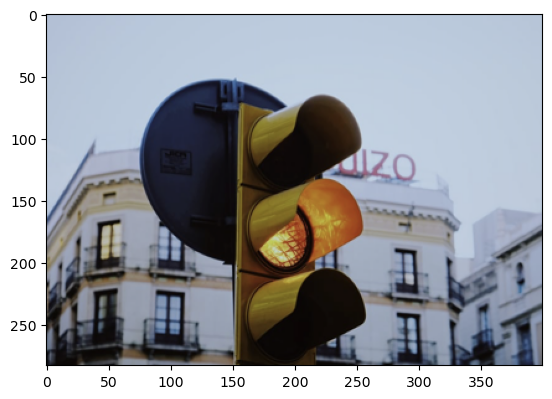

In [10]:
image_ids = df["image_id"].unique()
img_id = image_ids[1]
image = cv2.imread(f"./data/road-sign-detection/images/{img_id}", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [11]:
class RoadSignDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None, train=True):
        super().__init__()

        self.df = dataframe
        self.image_ids = dataframe["image_id"].unique()
        self.image_dir = image_dir
        self.transforms = transforms
        self.train = train

    def __len__(self) -> int:
        return len(self.image_ids)
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms is not None:
            image = self.transforms(image)
        if not self.train:
            return image, image_id
        records = self.df[self.df["image_id"] == image_id]
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values.astype(float)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels = []
        for label in records.get("label"):
            labels.append(class_to_idx[label])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {
            'boxes': boxes, 
            'labels': labels, 
            'image_id': torch.tensor([index]), 
            'area': area, 
            'iscrowd': iscrowd
        }
        
        return image, target, image_id

In [12]:
class Averager:  ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [44]:
train_dir = valid_dir = "./data/road-sign-detection/images"

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = RoadSignDataset(train_df, train_dir, transform, True)
valid_dataset = RoadSignDataset(valid_df, valid_dir, transform, True)

train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
valid_data_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [49]:
valid_dataset.__getitem__(5)

(tensor([[[0.6196, 0.6275, 0.6314,  ..., 0.6196, 0.6196, 0.6196],
          [0.6275, 0.6314, 0.6314,  ..., 0.6157, 0.6196, 0.6196],
          [0.6314, 0.6314, 0.6314,  ..., 0.6157, 0.6275, 0.6157],
          ...,
          [0.2235, 0.2196, 0.2314,  ..., 0.1529, 0.1490, 0.1490],
          [0.2000, 0.2039, 0.2118,  ..., 0.1529, 0.1529, 0.1686],
          [0.2078, 0.2039, 0.2039,  ..., 0.1451, 0.1412, 0.1529]],
 
         [[0.8275, 0.8235, 0.8275,  ..., 0.8235, 0.8275, 0.8275],
          [0.8353, 0.8275, 0.8275,  ..., 0.8196, 0.8235, 0.8235],
          [0.8314, 0.8275, 0.8275,  ..., 0.8235, 0.8275, 0.8196],
          ...,
          [0.3765, 0.3686, 0.3804,  ..., 0.2745, 0.2627, 0.2667],
          [0.3647, 0.3647, 0.3686,  ..., 0.2784, 0.2745, 0.2863],
          [0.3882, 0.3765, 0.3647,  ..., 0.2784, 0.2706, 0.2863]],
 
         [[0.8510, 0.8627, 0.8667,  ..., 0.8824, 0.8824, 0.8824],
          [0.8588, 0.8667, 0.8667,  ..., 0.8784, 0.8824, 0.8824],
          [0.8706, 0.8745, 0.8667,  ...,

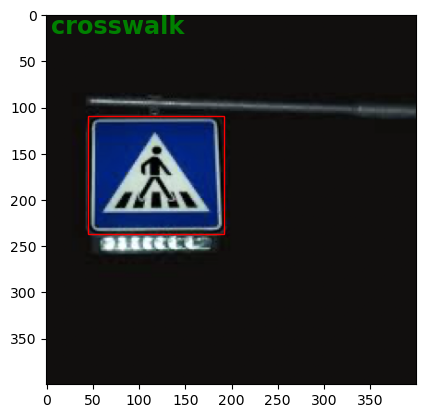

In [16]:
def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys[0]
    return None

see_examples = 10
for imgs, targets, image_ids in train_data_loader:
    print(type(imgs))
    clear_output(wait=True)
    coords = targets[4]['boxes'].numpy().astype(np.int32)[0]
    sample = imgs[4].permute(1, 2, 0).numpy()

    plt.imshow(sample)
    
    x1, y1, x2, y2 = coords
    rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(5, 20, get_key_from_value(class_to_idx, targets[4]["labels"]), fontsize='xx-large', color='g', fontweight='bold')
    plt.show()
    
    see_examples -= 1
    if see_examples < 0:
      break
    time.sleep(1)

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

In [19]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
num_classes = 4

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [21]:
print(train_data_loader.__len__())

94


In [22]:
import time

model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
#lr_scheduler = None

num_epochs = 3

loss_hist = Averager()

itr = 1
for epoch in range(num_epochs):
    start = time.time()
    loss_hist.reset()

    for images, targets, image_ids in train_data_loader:

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)  ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 10 == 0:
            end = time.time()
            print(f"Iteration #{itr} loss: {loss_value:.3f} time:{end-start:.1f}s")
            start = time.time()

        itr += 1

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #10 loss: 0.214 time:46.3s
Iteration #20 loss: 0.158 time:32.8s
Iteration #30 loss: 0.116 time:47.4s
Iteration #40 loss: 0.067 time:57.8s
Iteration #50 loss: 0.097 time:61.0s
Iteration #60 loss: 0.178 time:66.7s
Iteration #70 loss: 0.089 time:68.4s
Iteration #80 loss: 0.095 time:62.7s
Iteration #90 loss: 0.044 time:63.3s
Epoch #0 loss: 0.1574714939169427
Iteration #100 loss: 0.079 time:24.6s
Iteration #110 loss: 0.098 time:66.6s
Iteration #120 loss: 0.037 time:52.1s
Iteration #130 loss: 0.086 time:70.3s
Iteration #140 loss: 0.040 time:57.8s
Iteration #150 loss: 0.049 time:62.4s
Iteration #160 loss: 0.042 time:57.3s
Iteration #170 loss: 0.034 time:64.8s
Iteration #180 loss: 0.045 time:42.5s
Epoch #1 loss: 0.06246187508185493
Iteration #190 loss: 0.050 time:7.6s
Iteration #200 loss: 0.041 time:61.4s
Iteration #210 loss: 0.040 time:58.1s
Iteration #220 loss: 0.059 time:52.0s
Iteration #230 loss: 0.034 time:55.7s
Iteration #240 loss: 0.053 time:61.0s
Iteration #250 loss: 0.038 ti

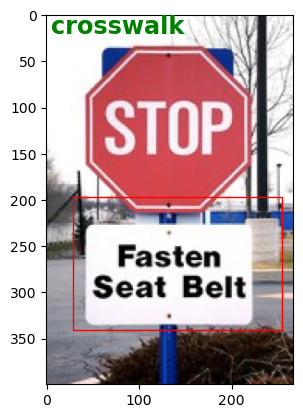

In [67]:
detection_threshold = 0.45
model.eval()
see_examples = 1111
for images, targets, image_ids in valid_data_loader:
    
    
    images = [image.to(device) for image in images]
    outputs = model(images)
    images = [image.cpu() for image in images]
    
    # plt.imshow(images[0])
    # plt.show()
    
    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        labels = outputs[i]['labels'].data.cpu().numpy()

        for box,scor,label in zip(boxes, scores, labels):
            if scor >= detection_threshold:
                clear_output(wait=True)
                sample = image.permute(1, 2, 0).numpy()
                
                plt.imshow(sample)
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
                plt.gca().add_patch(rect)
                plt.text(5, 20, get_key_from_value(class_to_idx, label), fontsize='xx-large', color='g', fontweight='bold')
                plt.show()
                
                see_examples -= 1
                if see_examples < 0:
                  break
                time.sleep(1)
        if see_examples < 0:
                  break
            

In [68]:
torch.save(model.state_dict(), "models/fastercnn_resnet50_3epochs_roadsigns")